# Import libraries

In [68]:
import os
from helpers import parse_variables
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from helpers import parse_variables
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helpers import parse_variables, get_risk_level, hi_gauss_blob_risk_fun, blob_risk_fun, NW_risk_fun, square_risk_fun, map_to_color, simulate_genos, calculate_true_maf_per_pop
from matplotlib.colors import LinearSegmentedColormap
import importlib.util
from models import ols_regression, manhattan_linear, gc

In [69]:
existing_risks = [
    "no_risk_fun",
    "NW_risk_fun",
    "N_risk_fun",
    "blob_risk_fun",
    "center_risk_fun",
    "big_square_risk_fun",
    "square_risk_fun",
    "hi_square_risk_fun",
    "mid_square_risk_fun",
    "mid_mid_square_risk_fun",
    "mid_mid_mid_square_risk_fun",
    "big_bad_square_risk_fun",
    "big_square_risk_fun_updated",
    "big_big_square_risk_fun",
    "big_big_big_square_risk_fun",
    "two_square_risk_fun",
    "three_square_risk_fun",
    "four_square_risk_fun",
    "as_big_blob_risk_fun",
    "six_square_risk_fun",
    "gauss_blob_risk_fun",
    "hi_gauss_blob_risk_fun"
]

In [70]:
risk = "hi_gauss_blob_risk_fun"

# Create genotype

In [71]:
dict = parse_variables('geno_simulation.txt')
G = 100
L = 10
c = 1000
k = 3
M = 20
HWE = 1

very_rare_to_save, rare_to_save, common_to_save, geno = simulate_genos(G, L, c, k, M, HWE)
proto_geno = geno.copy()

humans = pd.DataFrame()
number_of_populations = k*k
labels_pop = []
for i in range(number_of_populations):
    labels_pop += [i+1]*c

humans["populations"] = labels_pop

true_p2s, true_twopqs, true_q2s = calculate_true_maf_per_pop(geno, humans)

# visualise populations

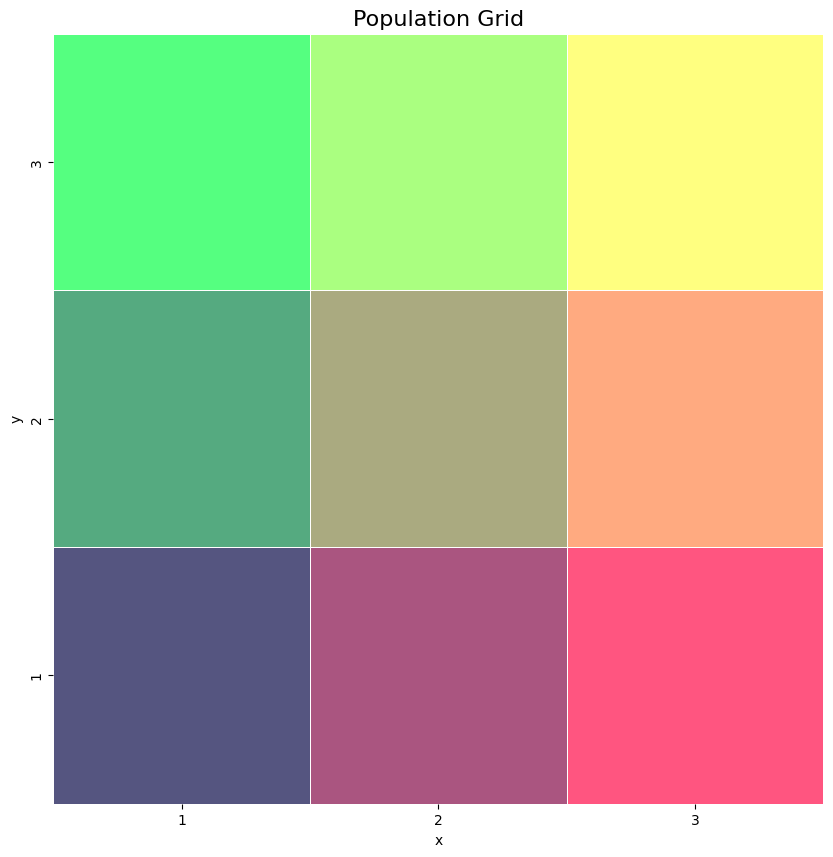

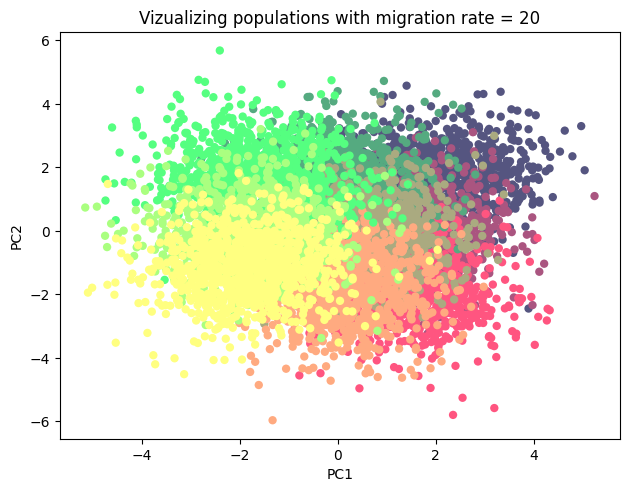

In [72]:
humans
humans['x'] = ((humans['populations'] - 1) % k) + 1
humans['y'] = ((humans['populations'] - 1) // k) + 1
humans['z'] = 0.5
palette = [map_to_color(x, y, z, humans) for x, y, z in zip(humans['x'], humans['y'], humans['z'])]
df_agg = humans.groupby(['x', 'y']).agg({'populations': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='populations')

# Use seaborn to create the heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()
plt.close()

scaler = StandardScaler()
scaled_geno = scaler.fit_transform(geno)
n_components = max(min(geno.shape[1], 50), 4)
pca = PCA(n_components=n_components)
pc_labels_complete = [f"PC{i}" for i in range(1, n_components + 1)]
PC_geno = pca.fit_transform(scaled_geno)
PC_geno = pd.DataFrame(data=PC_geno, columns=pc_labels_complete)

PC_geno['populations'] = humans['populations']

sns.scatterplot(x='PC1', y='PC2', data=PC_geno, color=palette, linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Vizualizing populations with migration rate = {M}")
plt.show()
plt.close()

# Create risks

<Axes: xlabel='x', ylabel='y'>

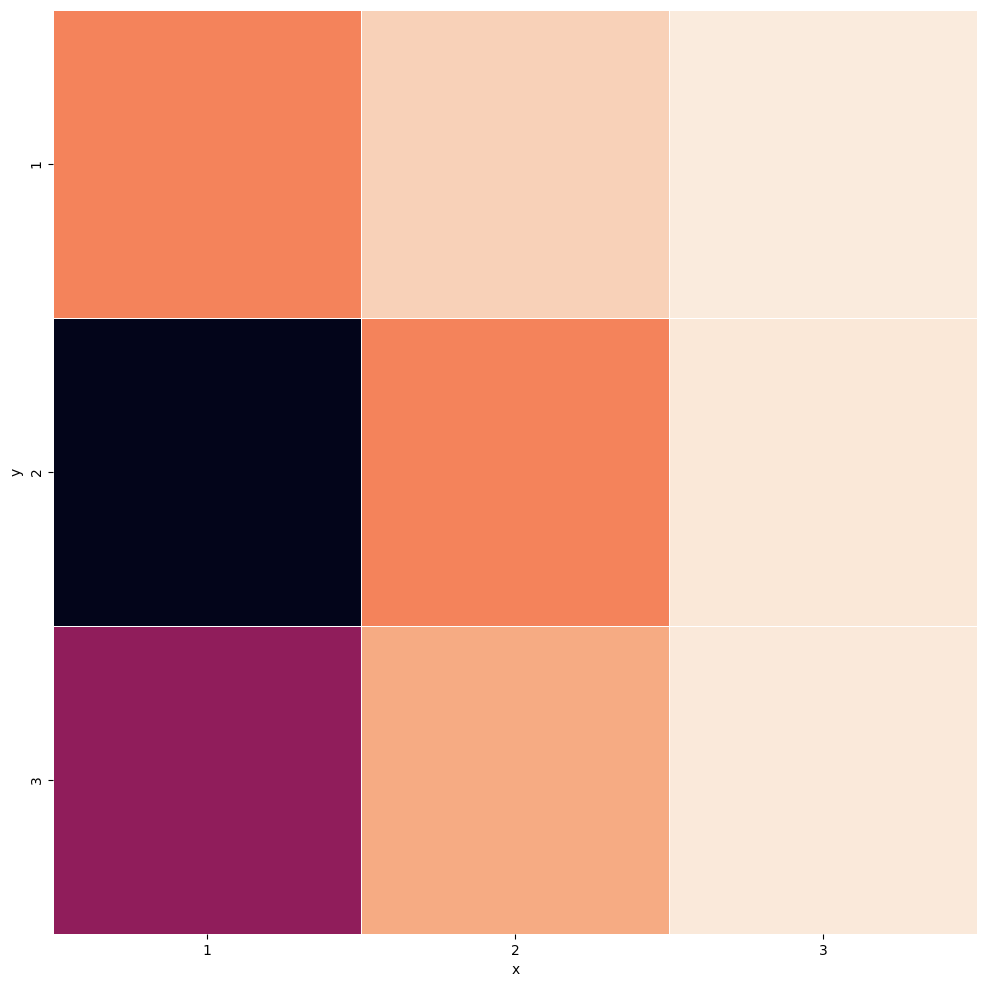

In [73]:
# Dynamically import the function based on the risk level
module_name = 'helpers'
module_spec = importlib.util.spec_from_file_location(module_name, 'helpers.py')
helpers = importlib.util.module_from_spec(module_spec)
module_spec.loader.exec_module(helpers)

risk_function = getattr(helpers, risk)
name_risk = risk.split('_fun')[0]
humans['x_temp'] = humans['x']/k
humans['y_temp'] = humans['y']/k
humans[name_risk] = list(humans.apply(lambda row: risk_function(row['x_temp'], row['y_temp']), axis=1))
humans[name_risk] = humans[name_risk].astype('float')

# Create subplots for each risk
fig, axs = plt.subplots(1, 1, figsize=(14, 12))
# Aggregate by x and y and calculate mean for each risk
df_agg = humans.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

In [74]:
name_risk

'hi_gauss_blob_risk'

# No correction only ENV

In [75]:
humans['risk'] = humans[name_risk] - humans[name_risk].mean()

y = humans['risk']
betas_snps = []
intercept_snps = []
logP_snps = []
mafs = []
max_beta = {}
for snp in geno.columns:
    beta_snps = manhattan_linear(geno[[snp]], y)
    betas_snps.append(beta_snps['coefs'][0])
    max_beta[snp] = abs(beta_snps['coefs'][0])
    logP_snps.append(beta_snps['-logPs'][0])
    mafs.append(float(snp.split('_')[-1]))

In [76]:
to_check = max(max_beta, key=max_beta.get)
to_check

'VRG204_AF_0.008444444444444444'

In [77]:
maf_dfs = pd.DataFrame(np.where(proto_geno == 1.0, true_p2s, np.where(proto_geno == 0.0, true_twopqs, true_q2s)), columns=proto_geno.columns)

In [78]:
nr_snps = maf_dfs[to_check]*c

In [79]:
humans['snp'] = proto_geno[to_check]
humans['pop'] = PC_geno['populations']
humans['snp_nr'] = nr_snps
X = humans[['snp']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['snp']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['snp']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

-0.5184374443406304


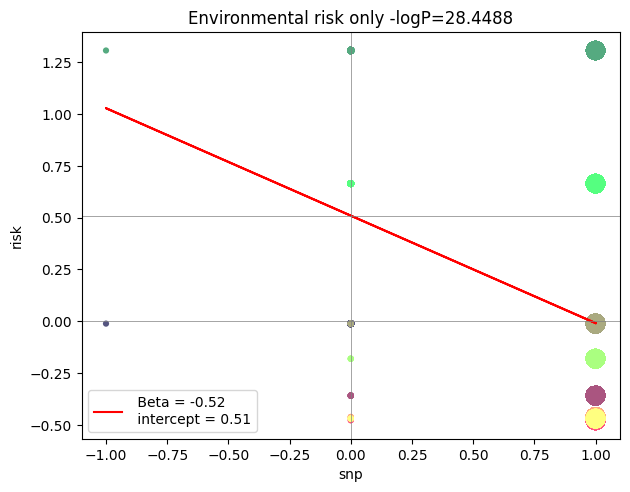

In [80]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='snp', y='risk', data=humans, color=palette, linewidth=0, legend=False, size='snp_nr',sizes=(20, 200))

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['snp'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

# X-X_means

In [81]:
humans['snp_mean'] = true_p2s[to_check] - true_q2s[to_check]
humans['snp_shifted'] = humans['snp'] - humans['snp_mean']

In [82]:
X = humans[['snp_shifted']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['snp_shifted']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['snp_shifted']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

-4.2049697057677804e-15


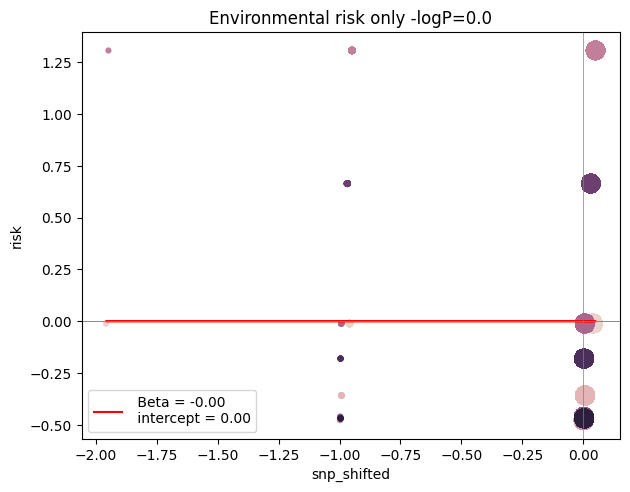

In [83]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='snp_shifted', y='risk', data=humans, size='snp_nr', hue='pop',sizes=(20, 200), linewidth=0, legend=False)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['snp_shifted'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()

plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

# Fake effect

In [84]:
humans['fake_effect'] = humans['snp']

In [85]:
X = humans[['snp_shifted']]  # Predictor variable
y = humans['fake_effect']    # Response variable
X = sm.add_constant(X)
# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta_fake = model.params['snp_shifted']
print(beta_fake)
intercept = model.params['const']
p_value_fake = model.pvalues['snp_shifted']
logp_value_fake = np.round(-np.log10(p_value),4)

humans['correcting_for_shift'] = model.predict(X)

1.000000000000006


In [86]:
humans['distances_from_fake_effect'] = humans['fake_effect'] - humans['correcting_for_shift']

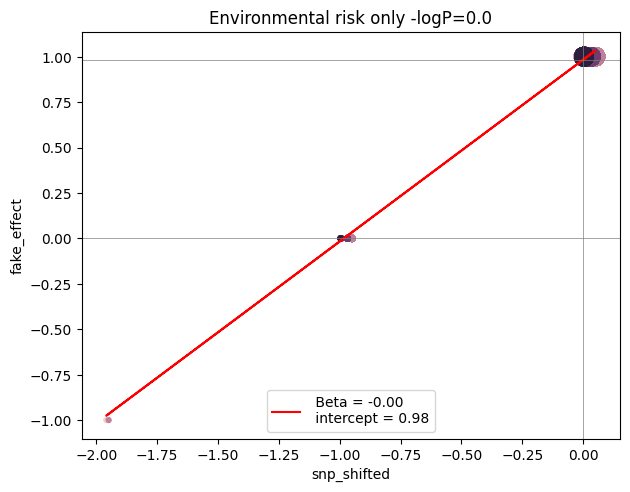

In [87]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='snp_shifted', y='fake_effect', data=humans, size='snp_nr', hue='pop',sizes=(20, 200), linewidth=0, legend=False)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['snp_shifted'], humans['correcting_for_shift'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()

plt.title(f"Environmental risk only -logP={logp_value_fake}")
plt.legend()

# Show the plot
plt.show()
plt.close()

In [88]:
humans

,populations,x,y,z,x_temp,y_temp,hi_gauss_blob_risk,risk,snp,pop,snp_nr,predicted_risk,snp_mean,snp_shifted,fake_effect,correcting_for_shift,distances_from_fake_effect
0,1,1,1,0.5,0.333333,0.333333,0.471754,-0.011308,1.0,1,960.0,2.280929e-15,0.959,0.041,1.0,1.024111,-0.024111
1,1,1,1,0.5,0.333333,0.333333,0.471754,-0.011308,1.0,1,960.0,2.280929e-15,0.959,0.041,1.0,1.024111,-0.024111
2,1,1,1,0.5,0.333333,0.333333,0.471754,-0.011308,1.0,1,960.0,2.280929e-15,0.959,0.041,1.0,1.024111,-0.024111
3,1,1,1,0.5,0.333333,0.333333,0.471754,-0.011308,1.0,1,960.0,2.280929e-15,0.959,0.041,1.0,1.024111,-0.024111
4,1,1,1,0.5,0.333333,0.333333,0.471754,-0.011308,1.0,1,960.0,2.280929e-15,0.959,0.041,1.0,1.024111,-0.024111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,9,3,3,0.5,1.000000,1.000000,0.013476,-0.469586,1.0,9,996.0,2.436513e-15,0.996,0.004,1.0,0.987111,0.012889
8996,9,3,3,0.5,1.000000,1.000000,0.013476,-0.469586,1.0,9,996.0,2.436513e-15,0.996,0.004,1.0,0.987111,0.012889
8997,9,3,3,0.5,1.000000,1.000000,0.013476,-0.469586,1.0,9,996.0,2.436513e-15,0.996,0.004,1.0,0.987111,0.012889
8998,9,3,3,0.5,1.000000,1.000000,0.013476,-0.469586,1.0,9,996.0,2.436513e-15,0.996,0.004,1.0,0.987111,0.012889


In [89]:
humans['distances_from_fake_effect']*(beta/beta_fake)

0       1.013865e-16
1       1.013865e-16
2       1.013865e-16
3       1.013865e-16
4       1.013865e-16
            ...     
8995   -5.419739e-17
8996   -5.419739e-17
8997   -5.419739e-17
8998   -5.419739e-17
8999   -5.419739e-17
Name: distances_from_fake_effect, Length: 9000, dtype: float64

In [90]:
humans['predicted_popstrat'] = humans['risk'] - humans['predicted_risk'] - humans['distances_from_fake_effect']*(beta/beta_fake)

# Go over all the snps

In [91]:
y = humans['risk']
betas_snps = []
intercept_snps = []
logP_snps = []

betas_snps_shifted = []
intercept_snps_shifted = []
logP_snps_shifted = []

estimated_env_risk = []

mafs = []

for snp in geno.columns:
    shifted = (geno[[f"{snp}"]]-true_p2s[[snp]] + true_q2s[[snp]])
    
    params_snps = manhattan_linear(geno[[snp]], y)
    beta_snp = params_snps['coefs'][0]
    intercept_snp = params_snps['intercept'][0]
    betas_snps.append(beta_snp)
    intercept_snps.append(intercept_snp)
    logP_snps.append(params_snps['-logPs'][0])
    
    params_snp_shifted = manhattan_linear(shifted[[snp]], y)
    beta_shifted = params_snp_shifted['coefs'][0]
    intercept_shifted = params_snp_shifted['intercept'][0]
    betas_snps_shifted.append(beta_shifted)
    intercept_snps_shifted.append(intercept_shifted)
    logP_snps_shifted.append(params_snp_shifted['-logPs'][0])
    
    params_fake = manhattan_linear(shifted[[snp]], geno[f"{snp}"])
    beta_fake = params_fake['coefs'][0]
    intercept_fake = params_fake['intercept'][0]
    X_0_pred = beta_fake*shifted[snp] + intercept_fake
    X_min_X_0_pred = geno[snp] - X_0_pred
    to_subtract = X_min_X_0_pred*(beta/beta_fake)

    pred_pheno = beta_shifted*shifted[snp] + intercept_shifted
    estimated_env_risk.append(y - pred_pheno-to_subtract)
    mafs.append(float(params_snps['AFs'][0]))

In [92]:
to_compare = pd.DataFrame()
to_compare['beta_snp'] = betas_snps
to_compare['intercept_snp'] = intercept_snps
to_compare['logP_snps'] = logP_snps

to_compare['beta_snp_shifted'] = betas_snps_shifted
to_compare['intercept_snp_shifted'] = intercept_snps_shifted
to_compare['logP_snps_shifted'] = logP_snps_shifted

to_compare['mafs'] = mafs

# Remove or cap the 'inf' values and extremely large numbers
to_compare = to_compare.replace([np.inf, -np.inf], np.nan)  # Replace 'inf' with NaN
to_compare['logP_snps'] = np.clip(to_compare['logP_snps'], 0, 200)  # Cap values at 100
to_compare['logP_snps_shifted'] = np.clip(to_compare['logP_snps_shifted'], 0, 200)  # Cap values at 100

In [93]:
to_compare

,beta_snp,intercept_snp,logP_snps,beta_snp_shifted,intercept_snp_shifted,logP_snps_shifted,mafs
0,-0.032094,0.008277,3.466009,2.602085e-18,2.453333e-15,9.643275e-17,0.371056
1,-0.011637,0.002540,0.735473,-3.426079e-17,2.453333e-15,1.350058e-15,0.390889
2,0.001285,-0.000274,0.054168,7.459311e-17,2.453333e-15,2.989415e-15,0.393444
3,-0.027297,0.013882,2.260649,-8.673617e-17,2.453333e-15,2.989415e-15,0.245722
4,-0.010062,0.001415,0.613131,5.551115e-17,2.453333e-15,2.217953e-15,0.429667
...,...,...,...,...,...,...,...
357,0.092013,-0.091461,0.634039,5.932754e-16,2.453333e-15,2.651901e-15,0.003000
358,0.134916,-0.129534,4.911531,1.117162e-15,2.453333e-15,1.243982e-14,0.019944
359,-0.115182,0.112750,2.222470,1.772887e-15,2.453333e-15,1.451313e-14,0.010556
360,0.034505,-0.034144,0.253041,-1.700029e-16,2.453333e-15,9.643275e-16,0.005222


In [94]:
to_compare = to_compare.round(4)
to_compare

,beta_snp,intercept_snp,logP_snps,beta_snp_shifted,intercept_snp_shifted,logP_snps_shifted,mafs
0,-0.0321,0.0083,3.4660,0.0,0.0,0.0,0.3711
1,-0.0116,0.0025,0.7355,-0.0,0.0,0.0,0.3909
2,0.0013,-0.0003,0.0542,0.0,0.0,0.0,0.3934
3,-0.0273,0.0139,2.2606,-0.0,0.0,0.0,0.2457
4,-0.0101,0.0014,0.6131,0.0,0.0,0.0,0.4297
...,...,...,...,...,...,...,...
357,0.0920,-0.0915,0.6340,0.0,0.0,0.0,0.0030
358,0.1349,-0.1295,4.9115,0.0,0.0,0.0,0.0199
359,-0.1152,0.1128,2.2225,0.0,0.0,0.0,0.0106
360,0.0345,-0.0341,0.2530,-0.0,0.0,0.0,0.0052


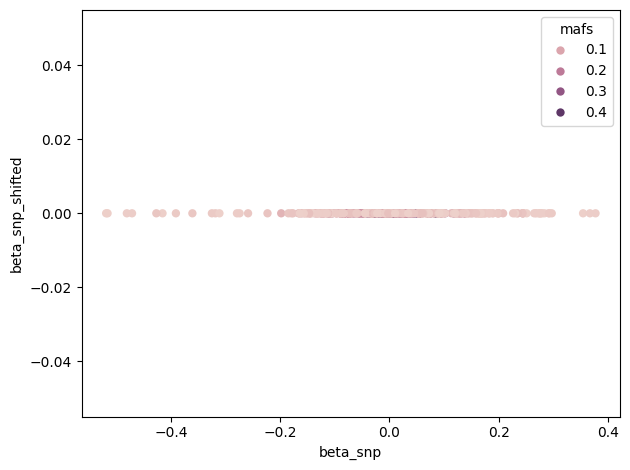

In [95]:
# Plot
sns.scatterplot(x='beta_snp', y='beta_snp_shifted', data=to_compare, hue='mafs', linewidth=0)
plt.tight_layout()
plt.title("")
plt.show()
plt.close()

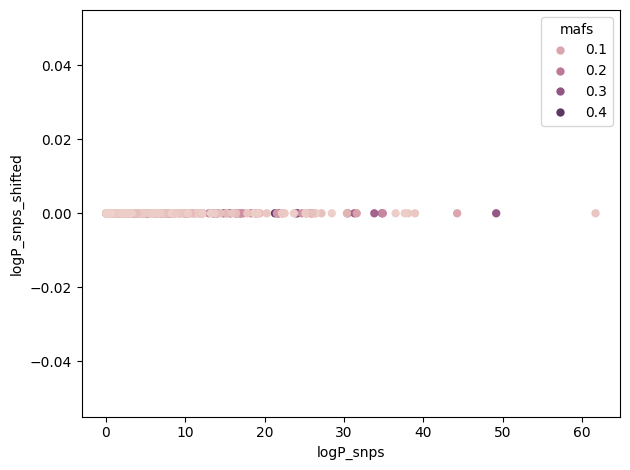

In [96]:
# Plot
sns.scatterplot(x='logP_snps', y='logP_snps_shifted', data=to_compare, hue='mafs', linewidth=0)
plt.tight_layout()
plt.title("")
plt.show()
plt.close()

In [97]:
estimated_env_risk_df = pd.DataFrame(estimated_env_risk).T
estimated_env_risk_df.columns = geno.columns
estimated_env_risk_df = estimated_env_risk_df.round(4)

## recreate the env landscape

In [98]:
estimated_env_risk_df

snps,CG15_AF_0.3710555555555556,CG16_AF_0.3908888888888889,CG19_AF_0.39344444444444443,CG28_AF_0.24572222222222223,CG45_AF_0.42966666666666664,CG53_AF_0.34933333333333333,CG54_AF_0.33355555555555555,CG63_AF_0.3446111111111111,CG67_AF_0.44005555555555553,CG69_AF_0.24438888888888888,...,VRG456_AF_0.0285,VRG466_AF_0.03788888888888889,VRG467_AF_0.018944444444444444,VRG468_AF_0.006611111111111111,VRG469_AF_0.0135,VRG475_AF_0.003,VRG477_AF_0.019944444444444445,VRG479_AF_0.010555555555555556,VRG483_AF_0.005222222222222222,VRG484_AF_0.011055555555555556
0,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,...,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113
1,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,...,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113
2,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,...,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113
3,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,...,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113
4,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,...,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113,-0.0113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,...,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696
8996,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,...,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696
8997,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,...,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696
8998,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,...,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696,-0.4696


<Axes: xlabel='x', ylabel='y'>

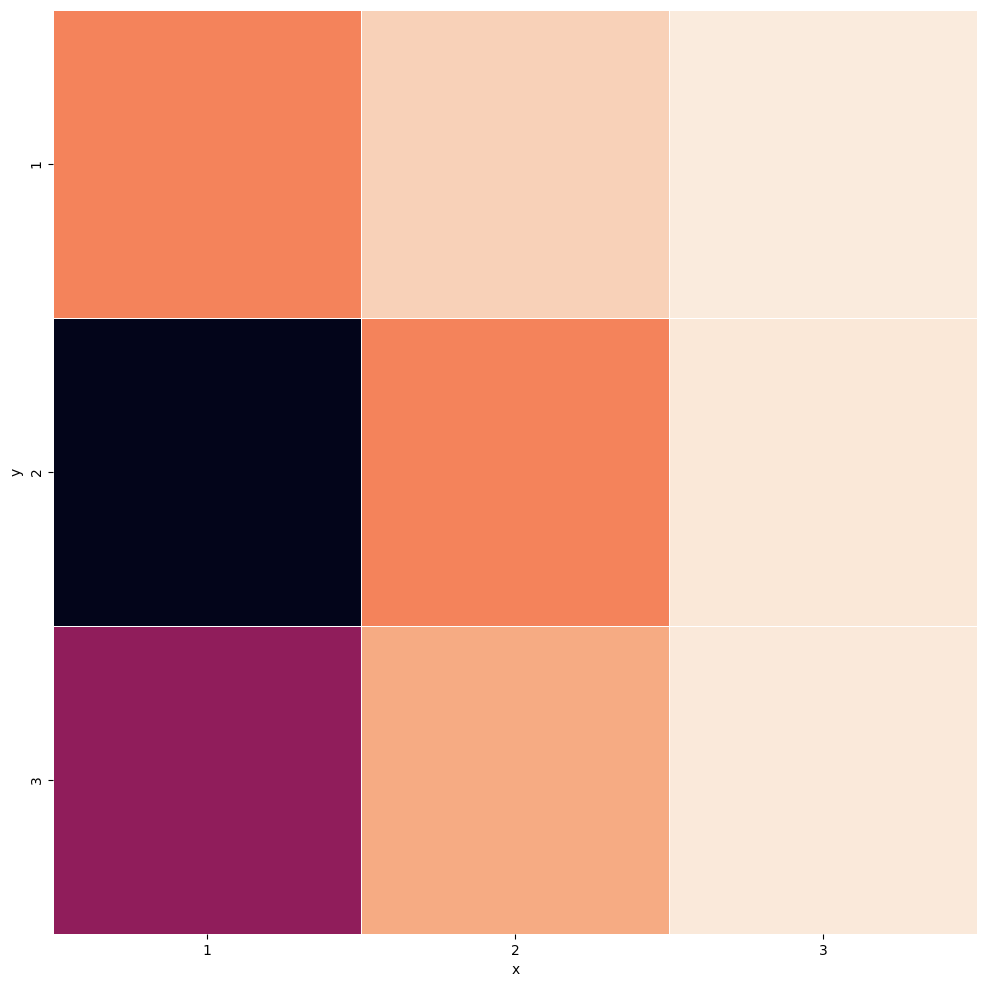

In [99]:
esti_risk = estimated_env_risk_df.mean(axis=1)
humans['esti_risk'] = esti_risk

# Create subplots for each risk
fig, axs = plt.subplots(1, 1, figsize=(14, 12))
# Aggregate by x and y and calculate mean for each risk
df_agg = humans.groupby(['x', 'y']).agg({'esti_risk': 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values='esti_risk')
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

## Check the biggest deviation

In [100]:
result_df = estimated_env_risk_df.sub(humans['risk'], axis=0)

In [101]:
# Compute the absolute values of the DataFrame
df_abs = result_df.abs()

# Find the maximum value in the entire DataFrame
max_value = df_abs.max().max()

# Find the column that contains this maximum value
to_check = df_abs.max().idxmax()

In [102]:
humans['snp'] = proto_geno[to_check]
humans['snp_mean'] = true_p2s[to_check] - true_q2s[to_check]
humans['snp_shifted'] = humans['snp'] - humans['snp_mean']

In [103]:
X = humans[['snp_shifted']]  # Predictor variable
y = humans['risk']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['snp_shifted']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['snp_shifted']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

2.6020852139652106e-18


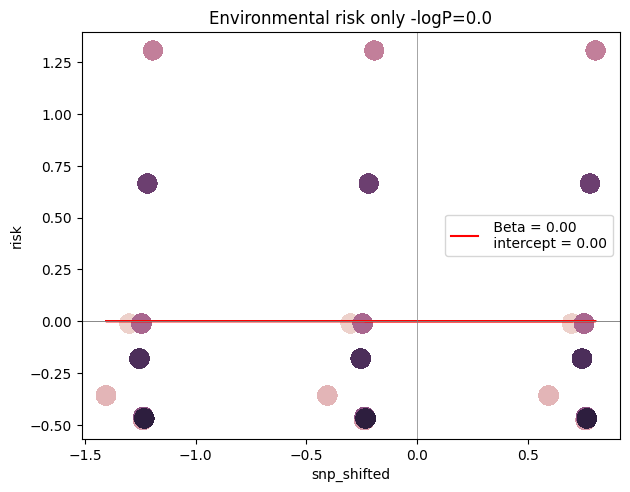

In [104]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='snp_shifted', y='risk', data=humans, size='snp_nr', hue='pop',sizes=(20, 200), linewidth=0, legend=False)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['snp_shifted'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()

plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

In [105]:
"""
df_stacked = estimated_env_risk_df.stack().reset_index(drop=True)
repeated_risk = humans['risk'].repeat(len(estimated_env_risk_df.columns)).reset_index(drop=True)
repeated_pop = humans['pop'].repeat(len(estimated_env_risk_df.columns)).reset_index(drop=True)
to_compare = pd.DataFrame()
to_compare['estimated_env_risk'] = df_stacked
to_compare['true_env_risk'] = repeated_risk
to_compare['pop'] = repeated_pop
# Plot
sns.scatterplot(x='true_env_risk', y='estimated_env_risk', data=to_compare, hue='pop', linewidth=0)
plt.tight_layout()
plt.title("")
plt.show()
plt.close()
"""

'\ndf_stacked = estimated_env_risk_df.stack().reset_index(drop=True)\nrepeated_risk = humans[\'risk\'].repeat(len(estimated_env_risk_df.columns)).reset_index(drop=True)\nrepeated_pop = humans[\'pop\'].repeat(len(estimated_env_risk_df.columns)).reset_index(drop=True)\nto_compare = pd.DataFrame()\nto_compare[\'estimated_env_risk\'] = df_stacked\nto_compare[\'true_env_risk\'] = repeated_risk\nto_compare[\'pop\'] = repeated_pop\n# Plot\nsns.scatterplot(x=\'true_env_risk\', y=\'estimated_env_risk\', data=to_compare, hue=\'pop\', linewidth=0)\nplt.tight_layout()\nplt.title("")\nplt.show()\nplt.close()\n'

# Causal effect

In [106]:
def divi(arr, effectsize):
    return [(1 / (num + 0.001)) * effectsize for num in arr]

In [107]:
af_values = geno.columns.str.extract(r'_AF_([\d\.]+)')[0].astype(float)
effectsize = 1
beta_values = divi(af_values, effectsize)
data = {'snp': list(geno.columns), 'Beta': beta_values}
betas = pd.DataFrame(data)

betas['maf_vals'] = af_values
betas['mafs'] = np.where(betas['maf_vals'] > 0.2, 'common', 
                      np.where(betas['maf_vals'] >= 0.05, 'rare', 'very rare'))

In [108]:
betas['Beta'] = 1
betas

,snp,Beta,maf_vals,mafs
0,CG15_AF_0.3710555555555556,1,0.371056,common
1,CG16_AF_0.3908888888888889,1,0.390889,common
2,CG19_AF_0.39344444444444443,1,0.393444,common
3,CG28_AF_0.24572222222222223,1,0.245722,common
4,CG45_AF_0.42966666666666664,1,0.429667,common
...,...,...,...,...
357,VRG475_AF_0.003,1,0.003000,very rare
358,VRG477_AF_0.019944444444444445,1,0.019944,very rare
359,VRG479_AF_0.010555555555555556,1,0.010556,very rare
360,VRG483_AF_0.005222222222222222,1,0.005222,very rare


In [109]:
snp_noise = 0.1

In [110]:
all_snps = list(geno.columns)
phenos_mono = []
for snp in all_snps:
    beta_value = betas.loc[betas['snp'] == snp, 'Beta'].values[0]
    phenos_mono.append(geno[snp] * beta_value)

# Converting phenos_mono list of series to DataFrame directly
phenos_mono = pd.concat(phenos_mono, axis=1)
phenos_mono.columns = geno.columns

# Add noise
n = len(phenos_mono)
for snp in list(phenos_mono.columns):
    var_effect = np.var(phenos_mono[snp])
    total_variance = var_effect / (1-snp_noise)
    var_noise = total_variance - var_effect
    sd_noise = np.sqrt(var_noise)
    # Generate phenotype with noise
    phenos_mono[snp] = phenos_mono[snp] + np.random.normal(0, sd_noise, n)

In [111]:
betas_snps = []
intercept_snps = []
logP_snps = []

betas_snps_shifted = []
intercept_snps_shifted = []
logP_snps_shifted = []

estimated_causal_risk = []

mafs = []

for snp in geno.columns:
    y = phenos_mono[snp]
    shifted = (geno[[f"{snp}"]]-true_p2s[[snp]] + true_q2s[[snp]])
    
    params_snps = manhattan_linear(geno[[snp]], y)
    beta_snp = params_snps['coefs'][0]
    intercept_snp = params_snps['intercept'][0]
    betas_snps.append(beta_snp)
    intercept_snps.append(intercept_snp)
    logP_snps.append(params_snps['-logPs'][0])
    
    params_snp_shifted = manhattan_linear(shifted[[snp]], y)
    beta_shifted = params_snp_shifted['coefs'][0]
    intercept_shifted = params_snp_shifted['intercept'][0]
    betas_snps_shifted.append(beta_shifted)
    intercept_snps_shifted.append(intercept_shifted)
    logP_snps_shifted.append(params_snp_shifted['-logPs'][0])
    
    params_fake = manhattan_linear(shifted[[snp]], geno[f"{snp}"])
    beta_fake = params_fake['coefs'][0]
    intercept_fake = params_fake['intercept'][0]
    X_0_pred = beta_fake*shifted[snp] + intercept_fake
    X_min_X_0_pred = geno[snp] - X_0_pred
    to_subtract = X_min_X_0_pred*(beta_shifted/beta_fake)

    pred_pheno = beta_shifted*shifted[snp] + intercept_shifted
    estimated_causal_risk.append(y - pred_pheno-to_subtract)
    mafs.append(float(params_snps['AFs'][0]))

In [112]:
to_compare = pd.DataFrame()
to_compare['beta_snp'] = betas_snps
to_compare['intercept_snp'] = intercept_snps
to_compare['logP_snps'] = logP_snps

to_compare['beta_snp_shifted'] = betas_snps_shifted
to_compare['intercept_snp_shifted'] = intercept_snps_shifted
to_compare['logP_snps_shifted'] = logP_snps_shifted

to_compare['mafs'] = mafs

# Remove or cap the 'inf' values and extremely large numbers
to_compare = to_compare.replace([np.inf, -np.inf], np.nan)  # Replace 'inf' with NaN
to_compare['logP_snps'] = np.clip(to_compare['logP_snps'], 0, 200)  # Cap values at 100
to_compare['logP_snps_shifted'] = np.clip(to_compare['logP_snps_shifted'], 0, 200)  # Cap values at 100

In [113]:
estimated_causal_risk_df = pd.DataFrame(estimated_causal_risk).T
estimated_causal_risk_df.columns = geno.columns
estimated_causal_risk_df = estimated_causal_risk_df.round(4)

In [114]:
estimated_causal_risk_df

snps,CG15_AF_0.3710555555555556,CG16_AF_0.3908888888888889,CG19_AF_0.39344444444444443,CG28_AF_0.24572222222222223,CG45_AF_0.42966666666666664,CG53_AF_0.34933333333333333,CG54_AF_0.33355555555555555,CG63_AF_0.3446111111111111,CG67_AF_0.44005555555555553,CG69_AF_0.24438888888888888,...,VRG456_AF_0.0285,VRG466_AF_0.03788888888888889,VRG467_AF_0.018944444444444444,VRG468_AF_0.006611111111111111,VRG469_AF_0.0135,VRG475_AF_0.003,VRG477_AF_0.019944444444444445,VRG479_AF_0.010555555555555556,VRG483_AF_0.005222222222222222,VRG484_AF_0.011055555555555556
0,-0.1477,0.2288,0.4033,0.0617,0.2333,-0.1876,-0.7016,-0.4204,-0.1464,-0.4742,...,0.0387,-0.0885,-0.0776,0.0162,0.0494,-0.0452,0.0158,0.0344,0.0196,0.0087
1,0.0108,0.2360,0.3183,0.2364,-0.3393,0.1551,0.2356,-0.1533,-0.1895,-0.0656,...,-0.1409,-0.1452,0.0674,0.0334,0.1269,0.0109,-0.0361,-0.0873,0.0608,-0.0093
2,0.0197,-0.1386,-0.1794,-0.1625,0.2446,-0.1507,0.2022,-0.3507,0.1984,0.3987,...,-0.0234,-0.0604,0.0842,0.0778,-0.0795,-0.0246,0.0533,0.0259,0.0112,0.0128
3,0.0406,-0.2546,0.5944,0.0436,-0.1029,-0.2476,-0.1794,-0.0142,0.1958,0.0838,...,0.1239,0.0126,0.1628,0.0835,0.0534,-0.0015,-0.0172,0.0364,0.0348,-0.0657
4,-0.0466,0.3961,0.4771,-0.3637,-0.0449,-0.4450,-0.0818,-0.1100,0.2410,-0.1481,...,-0.1350,-0.1417,0.0590,-0.0292,0.0839,-0.0588,0.0813,-0.0096,0.0023,-0.0052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.1594,-0.1061,0.0568,0.2778,-0.0648,-0.4651,-0.0689,0.1292,-0.0002,0.1329,...,-0.0298,0.0593,0.0041,-0.0472,0.0369,-0.0173,-0.1144,0.0269,0.0345,0.0443
8996,-0.2461,0.1667,0.0193,-0.0621,0.2151,0.1231,0.1484,-0.0600,0.1017,-0.0125,...,-0.0397,-0.1143,0.0291,-0.0569,-0.0325,0.0493,-0.0080,-0.0511,-0.0013,0.0451
8997,0.0646,0.3378,-0.4195,0.0926,-0.0698,0.2426,-0.0363,0.0342,0.4593,0.6913,...,0.1065,-0.0294,0.0861,-0.0285,-0.1153,-0.0272,-0.0137,-0.0003,0.0178,-0.0073
8998,0.0806,-0.2021,0.1368,-0.2897,-0.0688,0.0057,0.1938,0.0183,-0.3420,-0.0490,...,-0.1106,0.1476,-0.0751,0.0267,0.0340,0.0033,0.0330,-0.0374,0.0371,0.0326


In [115]:
row_means = estimated_causal_risk_df.mean(axis=1)
row_means.max()

0.028496132596685084

In [116]:
# Compute the absolute values of the DataFrame
df_abs = estimated_causal_risk_df.abs()

# Find the maximum value in the entire DataFrame
max_value = df_abs.max().max()

# Find the column that contains this maximum value
to_check = df_abs.max().idxmax()

In [117]:
max_value

1.2356

In [118]:
to_check

'CG461_AF_0.3493888888888889'

In [119]:
humans['snp'] = proto_geno[to_check]
humans['snp_mean'] = true_p2s[to_check] - true_q2s[to_check]
humans['snp_shifted'] = humans['snp'] - humans['snp_mean']
humans['risk_causal'] = phenos_mono[to_check] 

In [120]:
X = humans[['snp_shifted']]  # Predictor variable
y = humans['risk_causal']    # Response variable

# Add a constant to the predictor variable (for intercept)
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.OLS(y, X).fit()

# Extract beta (slope), intercept, and p-value
beta = model.params['snp_shifted']
print(beta)
intercept = model.params['const']
p_value = model.pvalues['snp_shifted']
logp_value = np.round(-np.log10(p_value),4)

humans['predicted_risk'] = model.predict(X)

1.0034646771654403


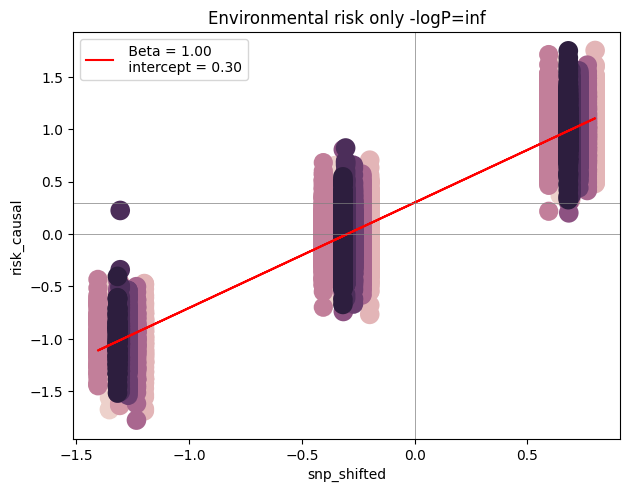

In [121]:
# Create the scatter plot with seaborn, using size to represent pop_quantity
sns.scatterplot(x='snp_shifted', y='risk_causal', data=humans, size='snp_nr', hue='pop',sizes=(20, 200), linewidth=0, legend=False)

# Add the regression line to the plot (no size argument here, as it's a line)
plt.plot(humans['snp_shifted'], humans['predicted_risk'], color='red', label=f' Beta = {beta:.2f}\n intercept = {intercept:.2f}')

# Add thin gray lines at x = 0 and y = 0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=intercept, color='gray', linestyle='-', linewidth=0.5)  # Vertical line at x = 0
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

# Adjust layout
plt.tight_layout()

plt.title(f"Environmental risk only -logP={logp_value}")
plt.legend()

# Show the plot
plt.show()
plt.close()

<Axes: xlabel='x', ylabel='y'>

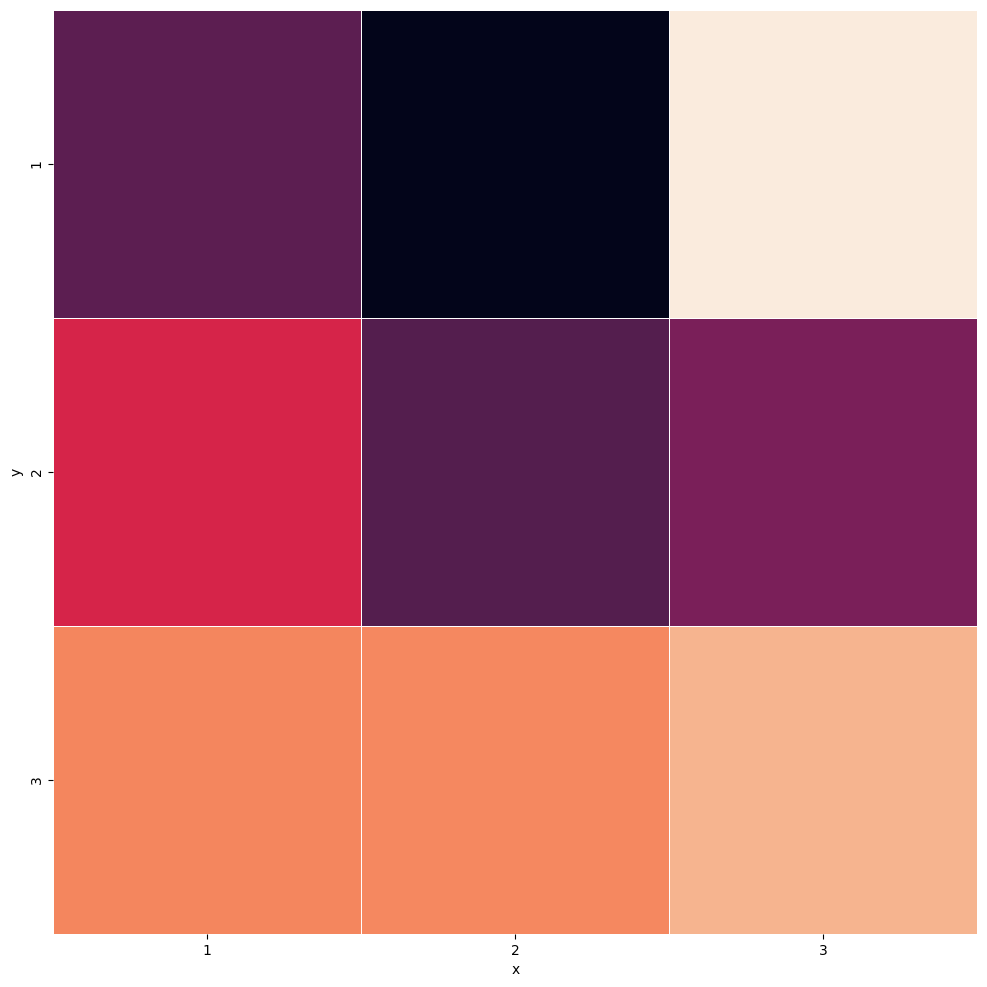

In [122]:
esti_risk = estimated_causal_risk_df.mean(axis=1)
humans['esti_risk'] = esti_risk

# Create subplots for each risk
fig, axs = plt.subplots(1, 1, figsize=(14, 12))
# Aggregate by x and y and calculate mean for each risk
df_agg = humans.groupby(['x', 'y']).agg({'esti_risk': 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values='esti_risk')
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

# Combinaison

In [123]:
ratio_effect = 0.9
ratio_environment = 1-ratio_effect

In [124]:
humans

,populations,x,y,z,x_temp,y_temp,hi_gauss_blob_risk,risk,snp,pop,snp_nr,predicted_risk,snp_mean,snp_shifted,fake_effect,correcting_for_shift,distances_from_fake_effect,predicted_popstrat,esti_risk,risk_causal
0,1,1,1,0.5,0.333333,0.333333,0.471754,-0.011308,0.0,1,960.0,-0.055663,0.354,-0.354,1.0,1.024111,-0.024111,-0.011308,0.002624,-0.062828
1,1,1,1,0.5,0.333333,0.333333,0.471754,-0.011308,0.0,1,960.0,-0.055663,0.354,-0.354,1.0,1.024111,-0.024111,-0.011308,0.010504,0.246843
2,1,1,1,0.5,0.333333,0.333333,0.471754,-0.011308,0.0,1,960.0,-0.055663,0.354,-0.354,1.0,1.024111,-0.024111,-0.011308,-0.002810,0.214751
3,1,1,1,0.5,0.333333,0.333333,0.471754,-0.011308,1.0,1,960.0,0.947802,0.354,0.646,1.0,1.024111,-0.024111,-0.011308,-0.004557,0.972040
4,1,1,1,0.5,0.333333,0.333333,0.471754,-0.011308,1.0,1,960.0,0.947802,0.354,0.646,1.0,1.024111,-0.024111,-0.011308,-0.003936,0.861063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,9,3,3,0.5,1.000000,1.000000,0.013476,-0.469586,0.0,9,996.0,-0.019538,0.318,-0.318,1.0,0.987111,0.012889,-0.469586,-0.007696,-0.346843
8996,9,3,3,0.5,1.000000,1.000000,0.013476,-0.469586,0.0,9,996.0,-0.019538,0.318,-0.318,1.0,0.987111,0.012889,-0.469586,-0.010456,-0.511447
8997,9,3,3,0.5,1.000000,1.000000,0.013476,-0.469586,1.0,9,996.0,0.983927,0.318,0.682,1.0,0.987111,0.012889,-0.469586,0.004510,1.174494
8998,9,3,3,0.5,1.000000,1.000000,0.013476,-0.469586,1.0,9,996.0,0.983927,0.318,0.682,1.0,0.987111,0.012889,-0.469586,0.004360,1.084195


In [125]:
betas_snps = []
intercept_snps = []
logP_snps = []

betas_snps_shifted = []
intercept_snps_shifted = []
logP_snps_shifted = []

estimated_causal_risk = []

mafs = []

for snp in geno.columns:
    y = phenos_mono[snp]*ratio_effect + humans['risk']*ratio_environment
    y = y - y.mean()
    shifted = (geno[[f"{snp}"]]-true_p2s[[snp]] + true_q2s[[snp]])
    
    params_snps = manhattan_linear(geno[[snp]], y)
    beta_snp = params_snps['coefs'][0]
    intercept_snp = params_snps['intercept'][0]
    betas_snps.append(beta_snp)
    intercept_snps.append(intercept_snp)
    logP_snps.append(params_snps['-logPs'][0])
    
    params_snp_shifted = manhattan_linear(shifted[[snp]], y)
    beta_shifted = params_snp_shifted['coefs'][0]
    intercept_shifted = params_snp_shifted['intercept'][0]
    betas_snps_shifted.append(beta_shifted)
    intercept_snps_shifted.append(intercept_shifted)
    logP_snps_shifted.append(params_snp_shifted['-logPs'][0])
    
    params_fake = manhattan_linear(shifted[[snp]], geno[f"{snp}"])
    beta_fake = params_fake['coefs'][0]
    intercept_fake = params_fake['intercept'][0]
    X_0_pred = beta_fake*shifted[snp] + intercept_fake
    X_min_X_0_pred = geno[snp] - X_0_pred
    to_subtract = X_min_X_0_pred*(beta/beta_fake)

    pred_pheno = beta_shifted*shifted[snp] + intercept_shifted
    estimated_causal_risk.append(y - pred_pheno-to_subtract)
    mafs.append(float(params_snps['AFs'][0]))

In [126]:
to_compare = pd.DataFrame()
to_compare['beta_snp'] = betas_snps
to_compare['intercept_snp'] = intercept_snps
to_compare['logP_snps'] = logP_snps

to_compare['beta_snp_shifted'] = betas_snps_shifted
to_compare['intercept_snp_shifted'] = intercept_snps_shifted
to_compare['logP_snps_shifted'] = logP_snps_shifted

to_compare['mafs'] = mafs

# Remove or cap the 'inf' values and extremely large numbers
to_compare = to_compare.replace([np.inf, -np.inf], np.nan)  # Replace 'inf' with NaN
to_compare['logP_snps'] = np.clip(to_compare['logP_snps'], 0, 200)  # Cap values at 100
to_compare['logP_snps_shifted'] = np.clip(to_compare['logP_snps_shifted'], 0, 200)  # Cap values at 100

In [127]:
estimated_causal_risk_df = pd.DataFrame(estimated_causal_risk).T
estimated_causal_risk_df.columns = geno.columns
estimated_causal_risk_df = estimated_causal_risk_df.round(4)

In [128]:
estimated_causal_risk_df

snps,CG15_AF_0.3710555555555556,CG16_AF_0.3908888888888889,CG19_AF_0.39344444444444443,CG28_AF_0.24572222222222223,CG45_AF_0.42966666666666664,CG53_AF_0.34933333333333333,CG54_AF_0.33355555555555555,CG63_AF_0.3446111111111111,CG67_AF_0.44005555555555553,CG69_AF_0.24438888888888888,...,VRG456_AF_0.0285,VRG466_AF_0.03788888888888889,VRG467_AF_0.018944444444444444,VRG468_AF_0.006611111111111111,VRG469_AF_0.0135,VRG475_AF_0.003,VRG477_AF_0.019944444444444445,VRG479_AF_0.010555555555555556,VRG483_AF_0.005222222222222222,VRG484_AF_0.011055555555555556
0,-0.1764,0.0886,0.3369,0.0670,0.3310,-0.1195,-0.5273,-0.3115,-0.1852,-0.3715,...,0.0176,-0.0635,-0.0959,0.0011,0.0222,-0.0247,0.0182,0.0157,0.0080,-0.0014
1,-0.0336,0.0951,0.2604,0.2242,-0.1844,0.1890,0.3162,-0.0711,-0.2240,-0.0038,...,-0.1440,-0.1145,0.0345,0.0166,0.0920,0.0257,-0.0285,-0.0938,0.0451,-0.0177
2,-0.0257,-0.2421,-0.1876,-0.1348,0.3411,-0.0863,0.2861,-0.2487,0.1252,0.4141,...,-0.0382,-0.0382,0.0497,0.0566,-0.0937,-0.0062,0.0520,0.0080,0.0004,0.0023
3,-0.0068,-0.3464,0.5088,0.0507,0.0283,-0.1734,-0.0574,0.0541,0.1228,0.1307,...,0.0943,0.0275,0.1204,0.0618,0.0259,0.0146,-0.0115,0.0175,0.0217,-0.0684
4,-0.0853,0.2391,0.4033,-0.3158,0.0806,-0.3511,0.0305,-0.0321,0.1634,-0.0780,...,-0.1387,-0.1114,0.0270,-0.0397,0.0533,-0.0370,0.0772,-0.0239,-0.0075,-0.0139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.1225,-0.1211,0.0193,0.2989,-0.2220,-0.4933,-0.1322,-0.0533,0.0280,0.1170,...,-0.0668,-0.0305,-0.0441,-0.1007,0.0013,-0.0676,-0.1438,-0.0279,-0.0224,-0.0213
8996,-0.2425,0.1244,-0.0144,-0.0069,0.0299,0.0361,0.0634,-0.2236,0.1197,-0.0138,...,-0.0756,-0.1867,-0.0216,-0.1094,-0.0611,-0.0076,-0.0480,-0.0981,-0.0546,-0.0205
8997,0.0371,0.2784,-0.4094,0.1323,-0.2265,0.1436,-0.1028,-0.1388,0.4416,0.6196,...,0.0559,-0.1103,0.0296,-0.0838,-0.1357,-0.0765,-0.0532,-0.0524,-0.0374,-0.0676
8998,0.0516,-0.2075,0.0913,-0.2118,-0.2256,-0.0695,0.1043,-0.1531,-0.2796,-0.0467,...,-0.1395,0.0490,-0.1154,-0.0342,-0.0013,-0.0490,-0.0111,-0.0857,-0.0200,-0.0318


<Axes: xlabel='x', ylabel='y'>

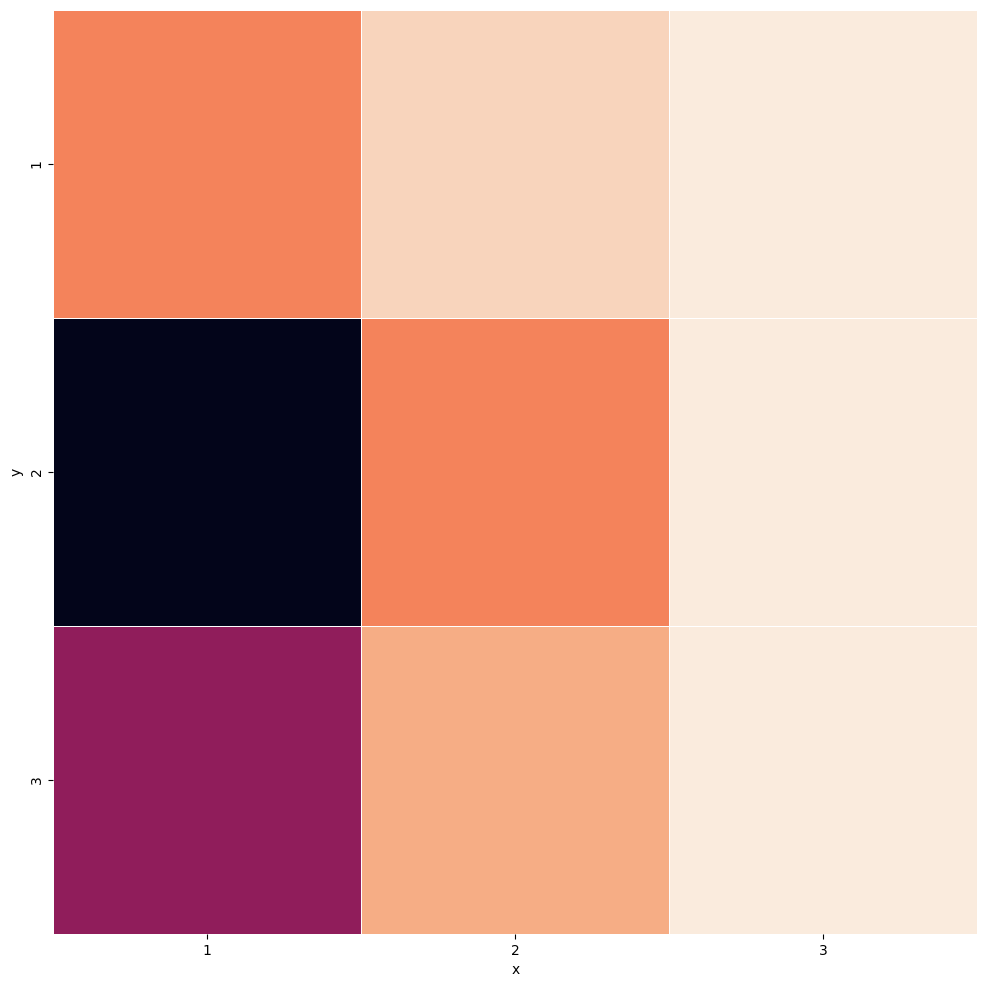

In [129]:
esti_risk = estimated_causal_risk_df.mean(axis=1)
humans['esti_risk'] = esti_risk

# Create subplots for each risk
fig, axs = plt.subplots(1, 1, figsize=(14, 12))
# Aggregate by x and y and calculate mean for each risk
df_agg = humans.groupby(['x', 'y']).agg({'esti_risk': 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values='esti_risk')
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)